# MIDAA Model both


In [1]:
import midaa as maa
import torch
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from scipy.sparse import issparse
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

c:\Users\DG1\Desktop\DALLAB\Experimenting\MIDAA_model\Models\vLIVE\MIDAA_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')
if device.type == 'cuda':
    torch.set_default_dtype(torch.float32)

Using device: cuda


In [3]:
# Load AnnData 
adata_path = r"C:\Users\DG1\Desktop\DALLAB\Experimenting\Data\Antibiotic resistance\BacDrop\further processing\random_adata_balanced.h5ad" #update if needed
assert os.path.exists(adata_path), f'File not found: {adata_path}'
adata = sc.read_h5ad(adata_path)
print(f'Loaded AnnData with shape: {adata.shape}')

Loaded AnnData with shape: (11493, 4514)


In [4]:
# Prepare treatment labels as a side matrix for classification loss
from sklearn.preprocessing import LabelBinarizer

treatment_labels = adata.obs['treatment'].astype(str).values
lb = LabelBinarizer()
y_onehot = lb.fit_transform(treatment_labels)
if y_onehot.shape[1] == 1:  # binary case
    y_onehot = np.hstack([1 - y_onehot, y_onehot])
side_matrices = [y_onehot.astype(np.float32)]
input_types_side = ["C"]

print(f'Classes: {lb.classes_}')

Classes: ['ciprofloxacin' 'gentamicin' 'meropenem']


In [5]:
# Prepare MIDAA input
input_data_raw, normalization_raw, input_distribution = maa.get_input_params_adata(adata)

def scipy_to_torch_sparse(csr_mat, device):
    coo = csr_mat.tocoo()
    indices = torch.tensor(np.vstack((coo.row, coo.col)), dtype=torch.long, device=device)
    values = torch.tensor(coo.data, dtype=torch.float32, device=device)
    shape = coo.shape
    return torch.sparse_coo_tensor(indices, values, shape).coalesce()

def convert_input_list(data_list):
    torch_list = []
    for x in data_list:
        if issparse(x):
            torch_list.append(scipy_to_torch_sparse(x, device))
        else:
            if isinstance(x, torch.Tensor):
                torch_list.append(x.to(device=device, dtype=torch.float32))
            else:
                torch_list.append(torch.tensor(x, dtype=torch.float32, device=device))
    return torch_list

input_data = convert_input_list(input_data_raw)
normalization = convert_input_list(normalization_raw)

In [6]:
# Hyperparameters
MULT = 4  # Network width multiplier to easily scale 
archetype_range = range(2, 10)  # change range as needed 
steps = 2000  # training steps 
lr = 5e-4  #  learning rate
batch_size = 4096  # batch size
torch_seed = 42  # for reproducibility
US_results = {}
S_results = {}

In [7]:
# Ensure cuda is being used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# make GPU the default for all new tensors
if device.type == "cuda":
    # Any torch.tensor(...) from now on will live on cuda:0
    torch.set_default_tensor_type(torch.cuda.FloatTensor)

Using device: cuda


c:\Users\DG1\Desktop\DALLAB\Experimenting\MIDAA_model\Models\vLIVE\MIDAA_env\Lib\site-packages\torch\__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


UnSupervised model 

In [8]:
#Run Unsupervised MIDAA
for narchetypes in archetype_range:
    print([x.device for x in input_data])
    print([x.device for x in normalization])
    print(f'\n--- Training with {narchetypes} archetypes ---')
    US_result = maa.fit_MIDAA(
        input_data,
        normalization,
        input_distribution,
        hidden_dims_dec_common=[64 * MULT, 128 * MULT],
        hidden_dims_dec_last=[256 * MULT],
        hidden_dims_enc_ind=[128 * MULT],
        hidden_dims_enc_common=[64 * MULT],
        hidden_dims_enc_pre_Z=[32 * MULT],
        lr=lr,
        gamma_lr=0.1,
        steps=steps,
        narchetypes=narchetypes,
        batch_size=batch_size,
        torch_seed=torch_seed,
    )
    US_results[narchetypes] = US_result  # Save the full result dict!
    print(f'Final ELBO for {narchetypes} archetypes: {US_result["ELBO"][-1]:.2f}')

[device(type='cuda', index=0)]
[device(type='cuda', index=0)]

--- Training with 2 archetypes ---


C:\Users\DG1\Desktop\DALLAB\Experimenting\MIDAA_model\midaa\src\midaa\Interface.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_matrix = [torch.tensor(x, dtype=torch.float32, device=device) for x in input_matrix]
C:\Users\DG1\Desktop\DALLAB\Experimenting\MIDAA_model\midaa\src\midaa\Interface.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  normalization_factor = [torch.tensor(x, dtype=torch.float32, device=device) for x in normalization_factor]
ELBO: 92758528.00000  : 100%|██████████| 2000/2000 [13:51<00:00,  2.41it/s]
c:\Users\DG1\Desktop\DALLAB\Experimenting\MIDAA_model\Models\vLIVE\MIDAA_env\Lib\site-packages\pyro\primitives.py:163: RuntimeWarning: trying to observe a v

Final ELBO for 2 archetypes: 92758528.00
[device(type='cuda', index=0)]
[device(type='cuda', index=0)]

--- Training with 3 archetypes ---


ELBO: 92757304.00000  : 100%|██████████| 2000/2000 [15:05<00:00,  2.21it/s]


Final ELBO for 3 archetypes: 92757304.00
[device(type='cuda', index=0)]
[device(type='cuda', index=0)]

--- Training with 4 archetypes ---


ELBO: 92730392.00000  : 100%|██████████| 2000/2000 [14:30<00:00,  2.30it/s]


Final ELBO for 4 archetypes: 92730392.00
[device(type='cuda', index=0)]
[device(type='cuda', index=0)]

--- Training with 5 archetypes ---


ELBO: 92735120.00000  : 100%|██████████| 2000/2000 [14:21<00:00,  2.32it/s]


Final ELBO for 5 archetypes: 92735120.00
[device(type='cuda', index=0)]
[device(type='cuda', index=0)]

--- Training with 6 archetypes ---


ELBO: 92720536.00000  : 100%|██████████| 2000/2000 [14:45<00:00,  2.26it/s]


Final ELBO for 6 archetypes: 92720536.00
[device(type='cuda', index=0)]
[device(type='cuda', index=0)]

--- Training with 7 archetypes ---


ELBO: 92715600.00000  : 100%|██████████| 2000/2000 [15:16<00:00,  2.18it/s]


Final ELBO for 7 archetypes: 92715600.00
[device(type='cuda', index=0)]
[device(type='cuda', index=0)]

--- Training with 8 archetypes ---


ELBO: 92697944.00000  : 100%|██████████| 2000/2000 [15:04<00:00,  2.21it/s]


Final ELBO for 8 archetypes: 92697944.00
[device(type='cuda', index=0)]
[device(type='cuda', index=0)]

--- Training with 9 archetypes ---


ELBO: 92689752.00000  : 100%|██████████| 2000/2000 [15:09<00:00,  2.20it/s]

Final ELBO for 9 archetypes: 92689752.00


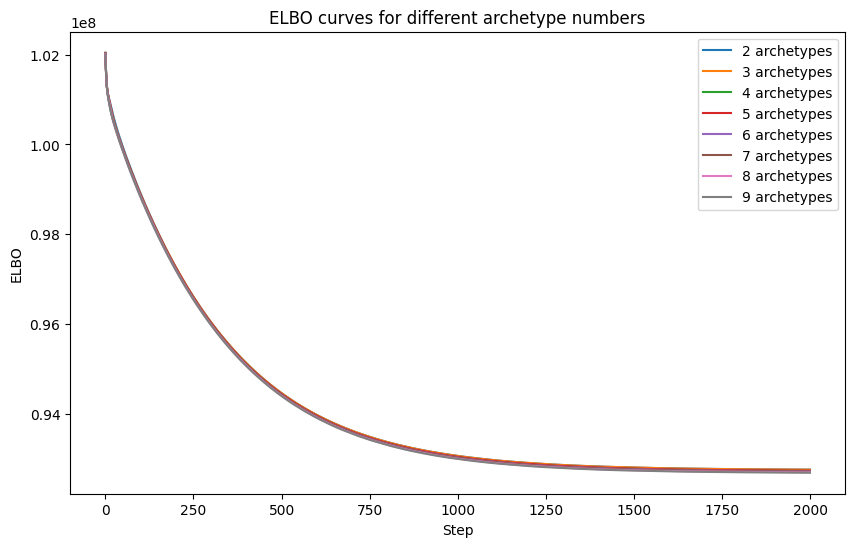

In [9]:
# Plot ELBO curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for narchetypes, US_result in US_results.items():
    plt.plot(US_result['ELBO'], label=f'{narchetypes} archetypes')
plt.xlabel('Step')
plt.ylabel('ELBO')
plt.title('ELBO curves for different archetype numbers')
plt.legend()
plt.show()

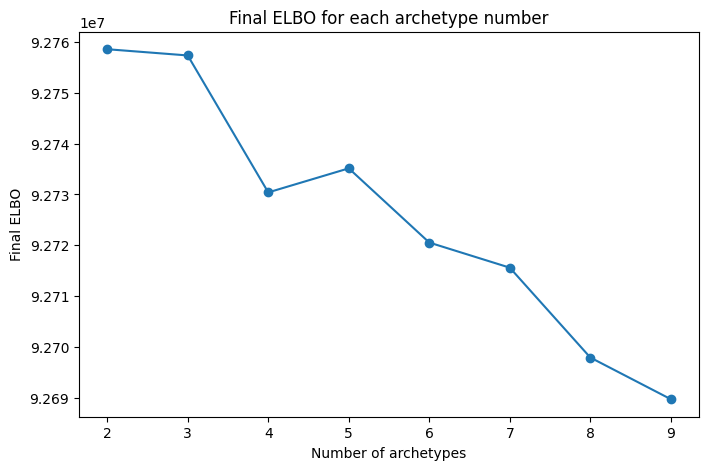

In [10]:
#plot final ELBO for each archetype
final_elbos = {narchetypes: US_result['ELBO'][-1] for narchetypes, US_result in US_results.items()}
plt.figure(figsize=(8, 5))
plt.plot(list(final_elbos.keys()), list(final_elbos.values()), marker='o')
plt.xlabel('Number of archetypes')
plt.ylabel('Final ELBO')
plt.title('Final ELBO for each archetype number')
plt.savefig("US_ELBO_2307rand.png")  # Save the plot as requested
plt.show()

In [11]:
import pickle


import torch

# Saving the US model with 5 archetypes 
best_narch = 5  # Integer instead of list
date_str = "US_rand1507" #DDMM  

print(f"Best number of archetypes: {best_narch}")

# Extract only the picklable data from best_result
best_result = US_results[best_narch]

# Create a clean dictionary with only picklable data
saveable_data = {
    "inferred_quantities": {},
    "ELBO": best_result["ELBO"],
    "hyperparameters": best_result["hyperparameters"]
}

# Extract and convert tensors to numpy arrays for the inferred quantities
for key, value in best_result["inferred_quantities"].items():
    if isinstance(value, torch.Tensor):
        saveable_data["inferred_quantities"][key] = value.detach().cpu().numpy()
    else:
        saveable_data["inferred_quantities"][key] = value

# Save the clean result dictionary with date
result_filename = f"best_midaa_result_{best_narch}arch_{date_str}.pkl"
with open(result_filename, "wb") as f:
    pickle.dump(saveable_data, f)
print(f"Successfully saved clean result dictionary to {result_filename}")

# Save the model state dict (model weights) with date
if "deepAA_obj" in best_result:
    model_filename = f"best_midaa_model_{best_narch}arch_{date_str}.pth"
    torch.save(best_result["deepAA_obj"].state_dict(), model_filename)
    print(f"Successfully saved model weights to {model_filename}")
else:
    print("Warning: No 'deepAA_obj' found in best_result")

Best number of archetypes: 5
Successfully saved clean result dictionary to best_midaa_result_5arch_US_rand1507.pkl
Successfully saved model weights to best_midaa_model_5arch_US_rand1507.pth


Supervised model

In [12]:
# Run MIDAA for a range of archetypes
for narchetypes in archetype_range:
    print([x.device for x in input_data])
    print([x.device for x in normalization])
    print(f'\n--- Training with {narchetypes} archetypes ---')
    S_result = maa.fit_MIDAA(
        input_data,
        normalization,
        input_distribution,
        side_matrices=side_matrices,  # newinput for classification loss
        input_types_side=input_types_side,
        hidden_dims_dec_common=[64 * MULT, 128 * MULT],
        hidden_dims_dec_last=[256 * MULT],
        hidden_dims_enc_ind=[128 * MULT],
        hidden_dims_enc_common=[64 * MULT],
        hidden_dims_enc_pre_Z=[32 * MULT],
        lr=lr,
        gamma_lr=0.1,
        steps=steps,
        narchetypes=narchetypes,
        batch_size=batch_size,
        torch_seed=torch_seed,
        CUDA=(device.type == 'cuda'),
        just_VAE=False
    )
    # Calculate classification accuracy for this run and save as metadata
    try:
        # Get predicted probabilities for the side matrix (classification)
        A, B, Z = S_result['deepAA_obj'].encoder(input_data)
        # The decoder returns (input_reconstructed, side_reconstructed)
        _, side_reconstructed = S_result['deepAA_obj'].decoder(Z)
        # side_reconstructed[0] shape: (n_samples, n_classes)
        pred_probs = torch.softmax(torch.tensor(side_reconstructed[0]), dim=1).detach().cpu().numpy()
        pred_labels = pred_probs.argmax(axis=1)
        true_labels = lb.transform(adata.obs['treatment'].astype(str).values).argmax(axis=1)
        acc = (pred_labels == true_labels).mean()
        S_result['classification_accuracy'] = acc
        print(f"Classification accuracy (MIDAA built-in): {acc:.4f}")
    except Exception as e:
        print(f"Could not compute classification accuracy for {narchetypes} archetypes: {e}")
        S_result['classification_accuracy'] = None

    S_results[narchetypes] = S_result  # Save the full result dict!
    print(f'Final ELBO for {narchetypes} archetypes: {S_result["ELBO"][-1]:.2f}')

[device(type='cuda', index=0)]
[device(type='cuda', index=0)]

--- Training with 2 archetypes ---


ELBO: 92762992.00000  : 100%|██████████| 2000/2000 [17:21<00:00,  1.92it/s]
C:\Users\DG1\AppData\Local\Temp\ipykernel_13304\1126596521.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_probs = torch.softmax(torch.tensor(side_reconstructed[0]), dim=1).detach().cpu().numpy()
C:\Users\DG1\Desktop\DALLAB\Experimenting\MIDAA_model\midaa\src\midaa\Interface.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_matrix = [torch.tensor(x, dtype=torch.float32, device=device) for x in input_matrix]
C:\Users\DG1\Desktop\DALLAB\Experimenting\MIDAA_model\midaa\src\midaa\Interface.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or

Classification accuracy (MIDAA built-in): 0.3372
Final ELBO for 2 archetypes: 92762992.00
[device(type='cuda', index=0)]
[device(type='cuda', index=0)]

--- Training with 3 archetypes ---


ELBO: 92758776.00000  : 100%|██████████| 2000/2000 [17:12<00:00,  1.94it/s]
c:\Users\DG1\Desktop\DALLAB\Experimenting\MIDAA_model\Models\vLIVE\MIDAA_env\Lib\site-packages\pyro\primitives.py:163: RuntimeWarning: trying to observe a value outside of inference at loss
  warnings.warn(
C:\Users\DG1\AppData\Local\Temp\ipykernel_13304\1126596521.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_probs = torch.softmax(torch.tensor(side_reconstructed[0]), dim=1).detach().cpu().numpy()
C:\Users\DG1\Desktop\DALLAB\Experimenting\MIDAA_model\midaa\src\midaa\Interface.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_matrix = [torch.tensor(x, dtype=torch.float32, device=device) for x 

Classification accuracy (MIDAA built-in): 0.3301
Final ELBO for 3 archetypes: 92758776.00
[device(type='cuda', index=0)]
[device(type='cuda', index=0)]

--- Training with 4 archetypes ---


ELBO: 92741712.00000  : 100%|██████████| 2000/2000 [16:49<00:00,  1.98it/s]
c:\Users\DG1\Desktop\DALLAB\Experimenting\MIDAA_model\Models\vLIVE\MIDAA_env\Lib\site-packages\pyro\primitives.py:163: RuntimeWarning: trying to observe a value outside of inference at loss
  warnings.warn(
C:\Users\DG1\AppData\Local\Temp\ipykernel_13304\1126596521.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_probs = torch.softmax(torch.tensor(side_reconstructed[0]), dim=1).detach().cpu().numpy()
C:\Users\DG1\Desktop\DALLAB\Experimenting\MIDAA_model\midaa\src\midaa\Interface.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_matrix = [torch.tensor(x, dtype=torch.float32, device=device) for x 

Classification accuracy (MIDAA built-in): 0.3339
Final ELBO for 4 archetypes: 92741712.00
[device(type='cuda', index=0)]
[device(type='cuda', index=0)]

--- Training with 5 archetypes ---


ELBO: 92732000.00000  : 100%|██████████| 2000/2000 [16:54<00:00,  1.97it/s]
c:\Users\DG1\Desktop\DALLAB\Experimenting\MIDAA_model\Models\vLIVE\MIDAA_env\Lib\site-packages\pyro\primitives.py:163: RuntimeWarning: trying to observe a value outside of inference at loss
  warnings.warn(
C:\Users\DG1\AppData\Local\Temp\ipykernel_13304\1126596521.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_probs = torch.softmax(torch.tensor(side_reconstructed[0]), dim=1).detach().cpu().numpy()
C:\Users\DG1\Desktop\DALLAB\Experimenting\MIDAA_model\midaa\src\midaa\Interface.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_matrix = [torch.tensor(x, dtype=torch.float32, device=device) for x 

Classification accuracy (MIDAA built-in): 0.3359
Final ELBO for 5 archetypes: 92732000.00
[device(type='cuda', index=0)]
[device(type='cuda', index=0)]

--- Training with 6 archetypes ---


ELBO: 92724704.00000  : 100%|██████████| 2000/2000 [16:53<00:00,  1.97it/s]
c:\Users\DG1\Desktop\DALLAB\Experimenting\MIDAA_model\Models\vLIVE\MIDAA_env\Lib\site-packages\pyro\primitives.py:163: RuntimeWarning: trying to observe a value outside of inference at loss
  warnings.warn(
C:\Users\DG1\AppData\Local\Temp\ipykernel_13304\1126596521.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_probs = torch.softmax(torch.tensor(side_reconstructed[0]), dim=1).detach().cpu().numpy()
C:\Users\DG1\Desktop\DALLAB\Experimenting\MIDAA_model\midaa\src\midaa\Interface.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_matrix = [torch.tensor(x, dtype=torch.float32, device=device) for x 

Classification accuracy (MIDAA built-in): 0.3367
Final ELBO for 6 archetypes: 92724704.00
[device(type='cuda', index=0)]
[device(type='cuda', index=0)]

--- Training with 7 archetypes ---


ELBO: 92719384.00000  : 100%|██████████| 2000/2000 [16:48<00:00,  1.98it/s]
c:\Users\DG1\Desktop\DALLAB\Experimenting\MIDAA_model\Models\vLIVE\MIDAA_env\Lib\site-packages\pyro\primitives.py:163: RuntimeWarning: trying to observe a value outside of inference at loss
  warnings.warn(
C:\Users\DG1\AppData\Local\Temp\ipykernel_13304\1126596521.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_probs = torch.softmax(torch.tensor(side_reconstructed[0]), dim=1).detach().cpu().numpy()
C:\Users\DG1\Desktop\DALLAB\Experimenting\MIDAA_model\midaa\src\midaa\Interface.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_matrix = [torch.tensor(x, dtype=torch.float32, device=device) for x 

Classification accuracy (MIDAA built-in): 0.3251
Final ELBO for 7 archetypes: 92719384.00
[device(type='cuda', index=0)]
[device(type='cuda', index=0)]

--- Training with 8 archetypes ---


ELBO: 92710448.00000  : 100%|██████████| 2000/2000 [17:10<00:00,  1.94it/s]
c:\Users\DG1\Desktop\DALLAB\Experimenting\MIDAA_model\Models\vLIVE\MIDAA_env\Lib\site-packages\pyro\primitives.py:163: RuntimeWarning: trying to observe a value outside of inference at loss
  warnings.warn(
C:\Users\DG1\AppData\Local\Temp\ipykernel_13304\1126596521.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_probs = torch.softmax(torch.tensor(side_reconstructed[0]), dim=1).detach().cpu().numpy()
C:\Users\DG1\Desktop\DALLAB\Experimenting\MIDAA_model\midaa\src\midaa\Interface.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_matrix = [torch.tensor(x, dtype=torch.float32, device=device) for x 

Classification accuracy (MIDAA built-in): 0.3336
Final ELBO for 8 archetypes: 92710448.00
[device(type='cuda', index=0)]
[device(type='cuda', index=0)]

--- Training with 9 archetypes ---


ELBO: 92696864.00000  : 100%|██████████| 2000/2000 [16:34<00:00,  2.01it/s]
c:\Users\DG1\Desktop\DALLAB\Experimenting\MIDAA_model\Models\vLIVE\MIDAA_env\Lib\site-packages\pyro\primitives.py:163: RuntimeWarning: trying to observe a value outside of inference at loss
  warnings.warn(
C:\Users\DG1\AppData\Local\Temp\ipykernel_13304\1126596521.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_probs = torch.softmax(torch.tensor(side_reconstructed[0]), dim=1).detach().cpu().numpy()


Classification accuracy (MIDAA built-in): 0.3283
Final ELBO for 9 archetypes: 92696864.00


Evaluating classification accuracy (unsure if this is approrpaite to keep as doesnt have an alternative for the unsupervised model)

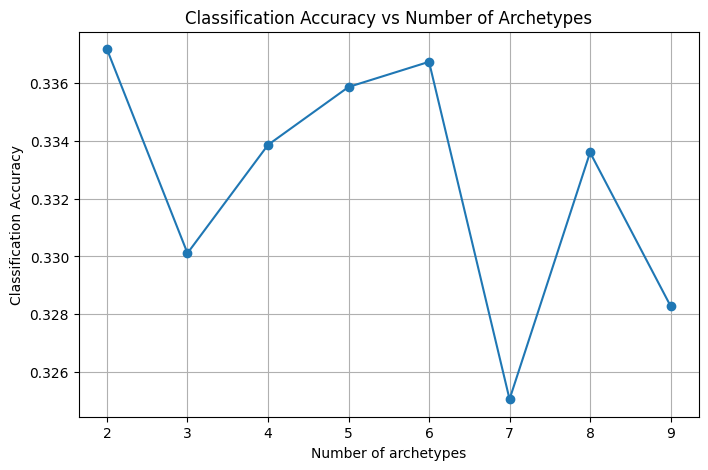

In [13]:
# Plot classification accuracy vs number of archetypes
import matplotlib.pyplot as plt

archetype_nums = []
accuracies = []
for narchetypes, S_result in S_results.items():
    acc = S_result.get('classification_accuracy', None)
    if acc is not None:
        archetype_nums.append(narchetypes)
        accuracies.append(acc)

plt.figure(figsize=(8, 5))
plt.plot(archetype_nums, accuracies, marker='o')
plt.xlabel('Number of archetypes')
plt.ylabel('Classification Accuracy')
plt.title('Classification Accuracy vs Number of Archetypes')
plt.grid(True)
plt.show()

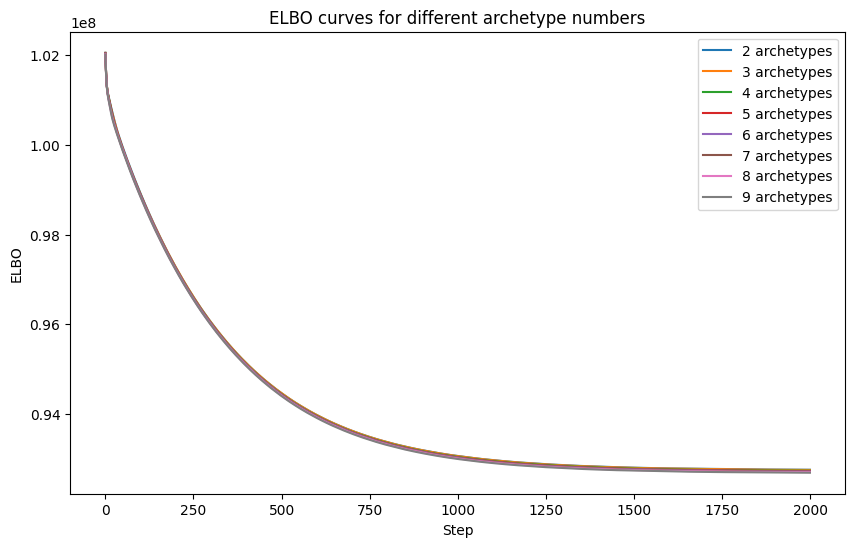

In [14]:
# Plot ELBO curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for narchetypes, S_result in S_results.items():
    plt.plot(S_result['ELBO'], label=f'{narchetypes} archetypes')
plt.xlabel('Step')
plt.ylabel('ELBO')
plt.title('ELBO curves for different archetype numbers')
plt.legend()
plt.show()

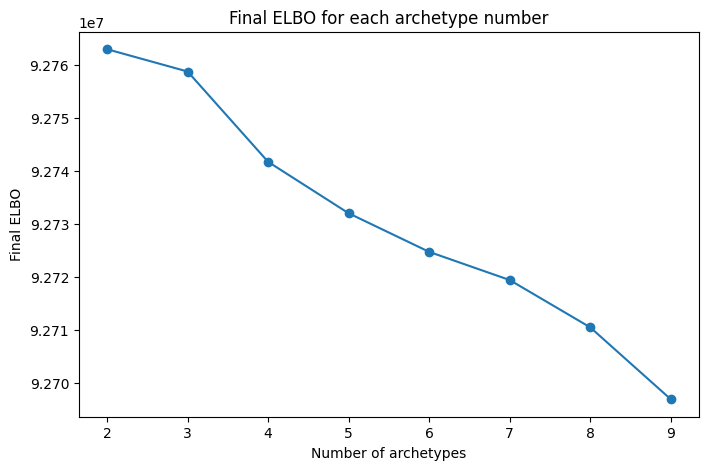

In [16]:
#plot final ELBO for each archetype
final_elbos = {narchetypes: S_result['ELBO'][-1] for narchetypes, S_result in S_results.items()}
plt.figure(figsize=(8, 5))
plt.plot(list(final_elbos.keys()), list(final_elbos.values()), marker='o')
plt.xlabel('Number of archetypes')
plt.ylabel('Final ELBO')
plt.title('Final ELBO for each archetype number')
plt.savefig("S_ELBO_2307rand.png")  # Save the plot as requested
plt.show()

## Model Selection
You can select the best number of archetypes based on the ELBO curve and downstream biological interpretability.

In [17]:
# Saving the S model with 5 archetypes 
best_narch = 5  # Integer instead of list
date_str = "S_rand2307" #DDMM  

print(f"Best number of archetypes: {best_narch}")

# Extract only the picklable data from best_result
best_result = S_results[best_narch]

# Create a clean dictionary with only picklable data
saveable_data = {
    "inferred_quantities": {},
    "ELBO": best_result["ELBO"],
    "hyperparameters": best_result["hyperparameters"]
}

# Extract and convert tensors to numpy arrays for the inferred quantities
for key, value in best_result["inferred_quantities"].items():
    if isinstance(value, torch.Tensor):
        saveable_data["inferred_quantities"][key] = value.detach().cpu().numpy()
    else:
        saveable_data["inferred_quantities"][key] = value

# Save the clean result dictionary with date
result_filename = f"best_midaa_result_{best_narch}arch_{date_str}.pkl"
with open(result_filename, "wb") as f:
    pickle.dump(saveable_data, f)
print(f"Successfully saved clean result dictionary to {result_filename}")

# Save the model state dict (model weights) with date
if "deepAA_obj" in best_result:
    model_filename = f"best_midaa_model_{best_narch}arch_{date_str}.pth"
    torch.save(best_result["deepAA_obj"].state_dict(), model_filename)
    print(f"Successfully saved model weights to {model_filename}")
else:
    print("Warning: No 'deepAA_obj' found in best_result")


Best number of archetypes: 5
Successfully saved clean result dictionary to best_midaa_result_5arch_S_rand2307.pkl
Successfully saved model weights to best_midaa_model_5arch_S_rand2307.pth


Importing for downprocessing

In [23]:
#reloading outputs of old model
import pickle

############## Unsupervised model########################

# Load the metadata/results dictionary
with open(r"C:\Users\DG1\Desktop\DALLAB\Experimenting\MIDAA_model\Models\vLIVE\output\2307_rand\best_midaa_result_5arch_US_rand1507.pkl", "rb") as f:
    US_best_result = pickle.load(f)

# Access the outputs
US_inferred_quantities = US_best_result["inferred_quantities"]  # e.g., A, B, Z matrices
US_ELBO = US_best_result["ELBO"]
US_hyperparameters = US_best_result["hyperparameters"]

# get the archetype assignment matrix A
US_A = US_inferred_quantities["A"]
US_B = US_inferred_quantities["B"]
US_Z = US_inferred_quantities["Z"]

##################### Supervised model########################
# Load the metadata/results dictionary
with open(r"C:\Users\DG1\Desktop\DALLAB\Experimenting\MIDAA_model\Models\vLIVE\output\2307_rand\best_midaa_result_5arch_S_rand2307.pkl", "rb") as f:
    S_best_result = pickle.load(f)

# Access the outputs
S_inferred_quantities = S_best_result["inferred_quantities"]  # e.g., A, B, Z matrices
S_ELBO = S_best_result["ELBO"]
S_hyperparameters = S_best_result["hyperparameters"]

# get the archetype assignment matrix A
S_A = S_inferred_quantities["A"]
S_B = S_inferred_quantities["B"]
S_Z = S_inferred_quantities["Z"]

## Post processing 
1. Completing p-value analysis
2. Genetic analysis of archetypes


In [24]:
#leveraging functinos developed for this purpose in AA_downstream_analysis.py
import sys
sys.path.append(r"C:\Users\DG1\Desktop\DALLAB\Experimenting\Analysis")
import AA_downstream_analysis
from AA_downstream_analysis import compute_simplex_volume, compute_convex_hull_volume, randomize_Z, null_t_ratios


### 1. Completing p-value analysis

#### a. Archetype coordinates in latent space 
Using a numpy function for linear least squares problem to solve for the arcehtypes coordinate in latent space. 

In [25]:
# Solve for archetype coordinates in latent space for both S_best and US_best
# This solves Z = A @ archetypes_latent for archetypes_latent

# For S_best
S_archetypes_latent, S_residuals, S_rank, S_s = np.linalg.lstsq(S_A, S_Z, rcond=None)
print("S_best archetype coordinates in latent space (shape: n_archetypes x latent_dim):")
print(S_archetypes_latent)
print(S_archetypes_latent.shape) # should be num of archetypes x latent dim

# For US_best
US_archetypes_latent, US_residuals, US_rank, US_s = np.linalg.lstsq(US_A, US_Z, rcond=None)
print("US_best archetype coordinates in latent space (shape: n_archetypes x latent_dim):")
print(US_archetypes_latent)
print(US_archetypes_latent.shape) # should be num of archetypes x latent dim

S_best archetype coordinates in latent space (shape: n_archetypes x latent_dim):
[[ 0.19373704  0.23959006  0.8970956  -0.8398928 ]
 [-0.91521424 -0.39108813  0.50011134 -0.585009  ]
 [ 0.39821643  0.39118835 -0.34671792  0.49337527]
 [-0.571038    0.05808732 -0.9260984   0.7713421 ]
 [ 1.2876759  -1.6285211  -0.33051866  0.08083487]]
(5, 4)
US_best archetype coordinates in latent space (shape: n_archetypes x latent_dim):
[[-1.036547   -0.60861844  0.12414005 -0.20417362]
 [-0.1463315   0.4342716  -0.9729837   0.18484037]
 [ 0.6151094   0.52910006 -0.45268545  0.43791524]
 [-0.02292774 -0.3733423   0.7803191  -0.57385194]
 [-0.11029071 -0.60482514  0.53168076  0.9462463 ]]
(5, 4)


#### b. Calculating the real simplex volume in latent space
Based on the same code that ParTI does to calculate the simplex volume in findMinSimplex.m function

In [26]:
# Compute simplex volumes for both S_best and US_best archetypes in latent space
S_real_simplex_volume = compute_simplex_volume(S_archetypes_latent)
US_real_simplex_volume = compute_simplex_volume(US_archetypes_latent)

print("S_best real simplex volume:", S_real_simplex_volume)
print("US_best real simplex volume:", US_real_simplex_volume)


S_best real simplex volume: 0.03581222891807556
US_best real simplex volume: 0.004995174705982208


#### c. calculating the complex hull of the original data in latent space
Leveraging the Z matrix generated by MIDAA.fit, and using convexhull functions from scipy to calculate the volume

In [37]:
# Calculate the convex hull and its volume for both S_best and US_best
S_real_convex_hull_volume = compute_convex_hull_volume(S_Z)
US_real_convex_hull_volume = compute_convex_hull_volume(US_Z)

print("S_best convex hull volume of the data in latent space:", S_convex_hull_volume)
print("US_best convex hull volume of the data in latent space:", US_convex_hull_volume)

S_best convex hull volume of the data in latent space: 3.5373958308425677
US_best convex hull volume of the data in latent space: 1.573638213311249


#### d. calculate real t-ratio
Equivalent to ParTI: simplex vol / convex hull vol

In [29]:
S_tRatioReal = S_real_simplex_volume / S_convex_hull_volume
US_tRatioReal = US_real_simplex_volume / US_convex_hull_volume
print("S_best tRatioReal:", S_tRatioReal)
print("US_best tRatioReal:", US_tRatioReal)

S_best tRatioReal: 0.01012389640023562
US_best tRatioReal: 0.003174284065885362


#### e. calculating randomised t-ratios in latent space
Match to ParTI method:
1. Randomly permute data along each latent dimensions independently 
2.Fit the polytope (keeping # arhcetypes the same) on the randomised data 
3. calculate t-ratio for the randomised dataset 
4. repeat 10000 times to create a distribution

In [ ]:
n_random = 10000
t_ratios_null = null_t_ratios(A, Z, n_random=n_random)

In [31]:
def null_t_ratios_QC(A, Z, n_random=1000): 
    t_ratios = []
    simplex_vols = []
    hull_vols = []
    n_archetypes = A.shape[1]
    for _ in range(n_random):
        # Randomise the latent space
        Z_rand = randomize_Z(Z)
        # Solve for new archetype coordinates in the randomised latent space for the same A and number of archetypes
        archetypes_latent_rand, *_ = np.linalg.lstsq(A, Z_rand, rcond=None) #solved using least squares, same as the real t-ratio model

        ########### QC on the randomised latent space ###########
        # Check if the randomly generated latent space is not the expected dimension
        if Z_rand.shape[1] != A.shape[1]-1:
            print(f"Error: Randomly generated latent space has dimension {Z_rand.shape[1]}, expected {A.shape[1]-1}.")
        
        if np.linalg.matrix_rank(archetypes_latent_rand) < archetypes_latent_rand.shape[1]:
            # Degenerate simplex, skip or set t-ratio to np.nan
            print("Degenerate simplex")
            t_ratios.append(np.nan)
            simplex_vols.append(np.nan)
            hull_vols.append(np.nan)
            continue
        #########################################################

        # Simplex volume
        simplex_vol = compute_simplex_volume(archetypes_latent_rand)
        # Convex hull volume
        hull_vol = compute_convex_hull_volume(Z_rand)
        # t-ratio
        t_ratios.append(simplex_vol / hull_vol) #simplex over convex hull
        simplex_vols.append(simplex_vol)
        hull_vols.append(hull_vol)

    return t_ratios, simplex_vols, hull_vols, Z_rand, archetypes_latent_rand

In [33]:
n_random = 1000

# For S_best_result
S_t_ratios_null, S_simplex_vols_null, S_hull_vols_null, S_Z_rand, S_archetypes_latent_rand = null_t_ratios_QC(S_A, S_Z, n_random=n_random)

# For US_best_result
US_t_ratios_null, US_simplex_vols_null, US_hull_vols_null, US_Z_rand, US_archetypes_latent_rand = null_t_ratios_QC(US_A, US_Z, n_random=n_random)

#### f. Calculating the p value 
Given MIDAA's volume is smaller than the convex hull for the simplex, extreme values of t are taken as ones that are larger (Closer to 1)


In [34]:
#using mean to get the p-value
US_p_value = np.mean(US_t_ratios_null >= US_tRatioReal)
print(f"US_p-value: {US_p_value:.100f}")

S_p_value = np.mean(S_t_ratios_null >= S_tRatioReal)
print(f"S_p-value: {S_p_value:.100f}")

US_p-value: 0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
S_p-value: 0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000


### Assessing process through visualisation


Visualising position of real t-ratio in the null distribution via histogram

Plotting distribution of random vs real convex hull and simplex volumes

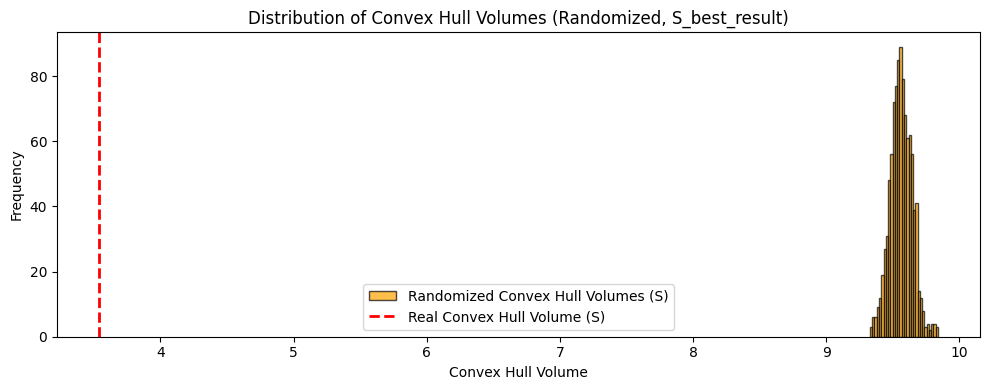

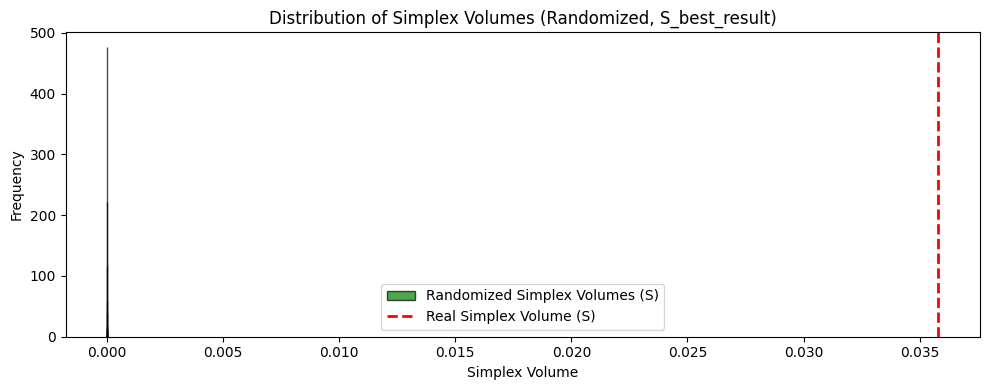

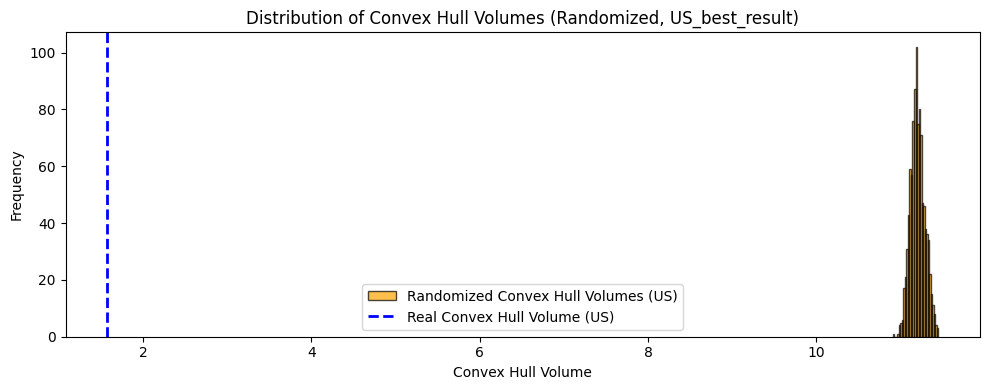

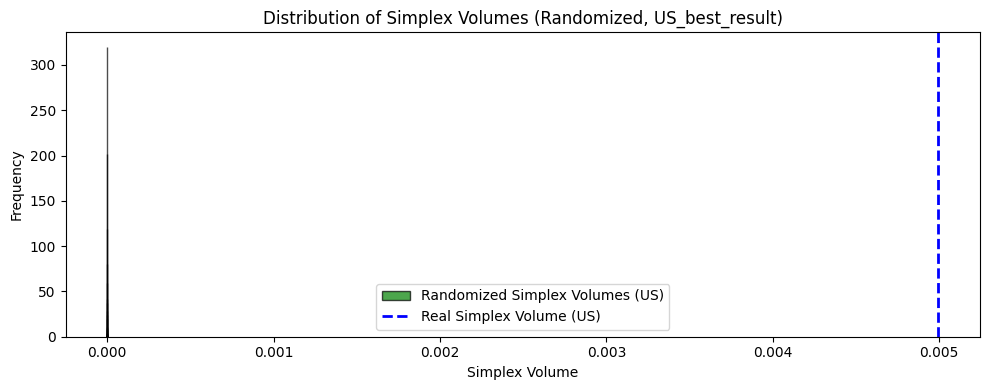

In [38]:
    # Plot the distribution of convex hull and simplex volumes with real value
    # for both S_best_result and US_best_result

    # --- S_best_result ---
    plt.figure(figsize=(10,4))
    plt.hist(S_hull_vols_null, bins=30, color='orange', edgecolor='black', alpha=0.7, label='Randomized Convex Hull Volumes (S)')
    plt.axvline(S_real_convex_hull_volume, color='red', linestyle='dashed', linewidth=2, label='Real Convex Hull Volume (S)')
    plt.xlabel('Convex Hull Volume')
    plt.ylabel('Frequency')
    plt.title('Distribution of Convex Hull Volumes (Randomized, S_best_result)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.hist(S_simplex_vols_null, bins=30, color='green', edgecolor='black', alpha=0.7, label='Randomized Simplex Volumes (S)')
    plt.axvline(S_real_simplex_volume, color='red', linestyle='dashed', linewidth=2, label='Real Simplex Volume (S)')
    plt.xlabel('Simplex Volume')
    plt.ylabel('Frequency')
    plt.title('Distribution of Simplex Volumes (Randomized, S_best_result)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- US_best_result ---
    plt.figure(figsize=(10,4))
    plt.hist(US_hull_vols_null, bins=30, color='orange', edgecolor='black', alpha=0.7, label='Randomized Convex Hull Volumes (US)')
    plt.axvline(US_real_convex_hull_volume, color='blue', linestyle='dashed', linewidth=2, label='Real Convex Hull Volume (US)')
    plt.xlabel('Convex Hull Volume')
    plt.ylabel('Frequency')
    plt.title('Distribution of Convex Hull Volumes (Randomized, US_best_result)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.hist(US_simplex_vols_null, bins=30, color='green', edgecolor='black', alpha=0.7, label='Randomized Simplex Volumes (US)')
    plt.axvline(US_real_simplex_volume, color='blue', linestyle='dashed', linewidth=2, label='Real Simplex Volume (US)')
    plt.xlabel('Simplex Volume')
    plt.ylabel('Frequency')
    plt.title('Distribution of Simplex Volumes (Randomized, US_best_result)')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

# Helper function to plot convex hull
def plot_convex_hull(ax, points, hull, color='orange', alpha=0.2, edgecolor='orange', label='Convex Hull'):
    for simplex in hull.simplices:
        simplex_points = points[simplex]
        ax.plot(simplex_points[:, 0], simplex_points[:, 1], '-', color=edgecolor, lw=2)
    # Fill the hull
    hull_path = points[hull.vertices]
    ax.fill(hull_path[:, 0], hull_path[:, 1], color=color, alpha=alpha, label=label)

# Helper function to plot simplex
def plot_simplex(ax, simplex_points, color='green', alpha=0.3, edgecolor='green', label='Simplex'):
    # Draw lines between all pairs of simplex vertices
    n = simplex_points.shape[0]
    for i in range(n):
        for j in range(i+1, n):
            ax.plot([simplex_points[i, 0], simplex_points[j, 0]],
                    [simplex_points[i, 1], simplex_points[j, 1]],
                    color=edgecolor, lw=2)
    # Fill the simplex
    ax.fill(simplex_points[:, 0], simplex_points[:, 1], color=color, alpha=alpha, label=label)


plt.show()


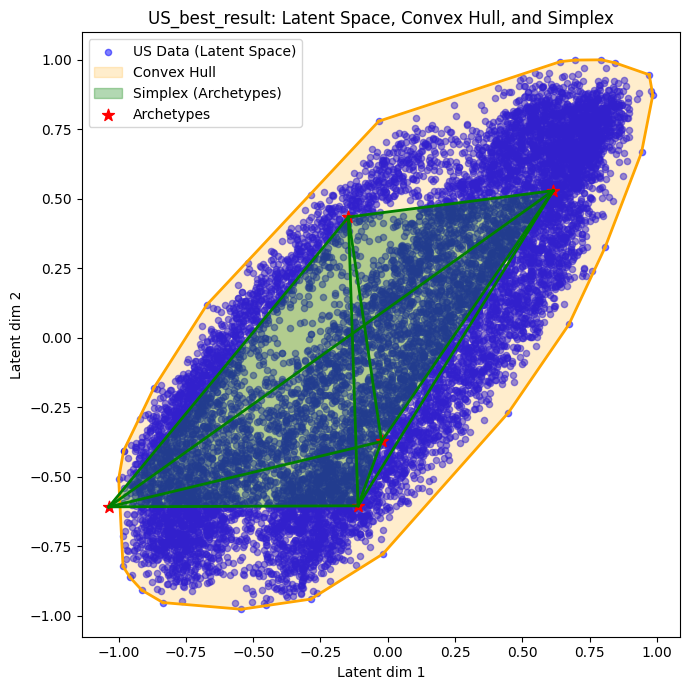

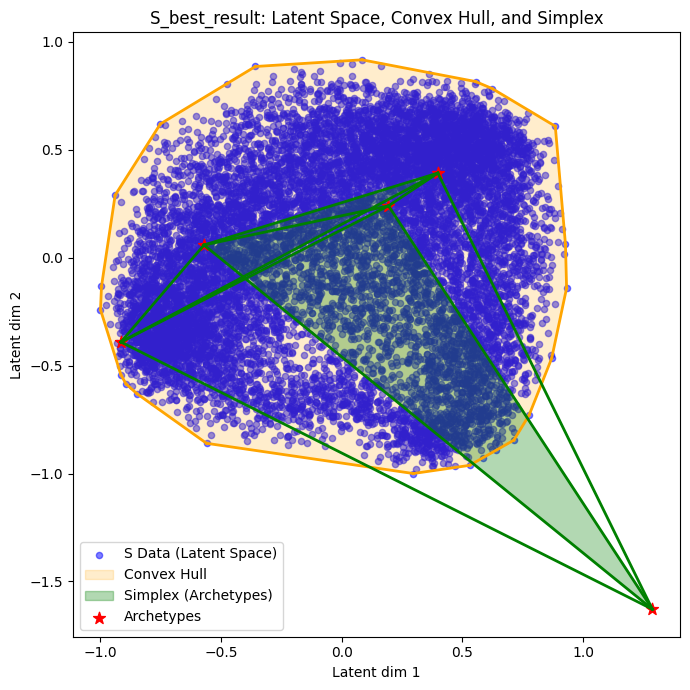

NameError: name 'archetypes_latent' is not defined

In [41]:
# --- Plot for real data: US_best_result ---
# Project to first 2 latent dimensions for US_best_result
US_Z_2d = US_Z[:, :2]
US_archetypes_latent_2d = US_archetypes_latent[:, :2]

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(US_Z_2d[:, 0], US_Z_2d[:, 1], s=20, color='blue', alpha=0.5, label='US Data (Latent Space)')
# Convex hull
US_hull_real = ConvexHull(US_Z_2d)
plot_convex_hull(ax, US_Z_2d, US_hull_real, color='orange', alpha=0.2, edgecolor='orange', label='Convex Hull')
# Simplex (archetypes)
plot_simplex(ax, US_archetypes_latent_2d, color='green', alpha=0.3, edgecolor='green', label='Simplex (Archetypes)')
ax.scatter(US_archetypes_latent_2d[:, 0], US_archetypes_latent_2d[:, 1], color='red', s=80, marker='*', label='Archetypes')
ax.set_title('US_best_result: Latent Space, Convex Hull, and Simplex')
ax.legend()
plt.xlabel('Latent dim 1')
plt.ylabel('Latent dim 2')
plt.tight_layout()
plt.show()

# --- Plot for real data: S_best_result ---
# Project to first 2 latent dimensions for S_best_result
S_Z_2d = S_Z[:, :2]
S_archetypes_latent_2d = S_archetypes_latent[:, :2]

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(S_Z_2d[:, 0], S_Z_2d[:, 1], s=20, color='blue', alpha=0.5, label='S Data (Latent Space)')
# Convex hull
S_hull_real = ConvexHull(S_Z_2d)
plot_convex_hull(ax, S_Z_2d, S_hull_real, color='orange', alpha=0.2, edgecolor='orange', label='Convex Hull')
# Simplex (archetypes)
plot_simplex(ax, S_archetypes_latent_2d, color='green', alpha=0.3, edgecolor='green', label='Simplex (Archetypes)')
ax.scatter(S_archetypes_latent_2d[:, 0], S_archetypes_latent_2d[:, 1], color='red', s=80, marker='*', label='Archetypes')
ax.set_title('S_best_result: Latent Space, Convex Hull, and Simplex')
ax.legend()
plt.xlabel('Latent dim 1')
plt.ylabel('Latent dim 2')
plt.tight_layout()
plt.show()
# Project to first 2 latent dimensions
UZ_2d = Z[:, :2]
archetypes_latent_2d = archetypes_latent[:, :2]

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(Z_2d[:, 0], Z_2d[:, 1], s=20, color='blue', alpha=0.5, label='Data (Latent Space)')
# Convex hull
hull_real = ConvexHull(Z_2d)
plot_convex_hull(ax, Z_2d, hull_real, color='orange', alpha=0.2, edgecolor='orange', label='Convex Hull')
# Simplex (archetypes)
plot_simplex(ax, archetypes_latent_2d, color='green', alpha=0.3, edgecolor='green', label='Simplex (Archetypes)')
ax.scatter(archetypes_latent_2d[:, 0], archetypes_latent_2d[:, 1], color='red', s=80, marker='*', label='Archetypes')
ax.set_title('Real Data: Latent Space, Convex Hull, and Simplex')
ax.legend()
plt.xlabel('Latent dim 1')
plt.ylabel('Latent dim 2')
plt.tight_layout()
plt.show()



### 2. Biological Interpretation of archetypes
a. Visualising archetypes by treatment and replicate

b. Genetic Analysis

#### a. Visualizing Archetypes by Treatment and Replicate

Aiming to understand any clear patterns from the metadata for archetype assignment

Using built in midaa function plot_archetypes_simplex()

AttributeError: 'Legend' object has no attribute 'legendHandles'

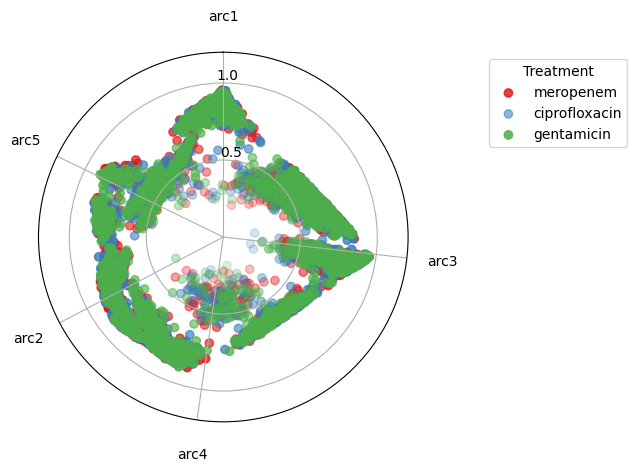

In [ ]:
import pandas as pd
from midaa import plot_archetypes_simplex

# Visualize archetype simplex for both S_best_result and US_best_result
# Ensure all 4 plots are shown and clearly labeled
results = [
    (S_best_result, "S_best_result"),
    (US_best_result, "US_best_result")
]

# For S_best_result
fig1, ax1 = plot_archetypes_simplex(
    S_best_result,
    color_by=adata.obs["treatment"],
    l_title="Treatment",
    cmap="Set1"
)
fig1.suptitle("Archetype Simplex by Treatment (S_best_result)")
fig1.show()

# # Get archetype assignments (A matrix) and metadata
# obs = adata.obs

# # Visualize by treatment
# fig, ax = maa.plot_archetypes_simplex(
#     best_result,
#     color_by=adata.obs["treatment"],
#     l_title="Treatment",
#     cmap = "Set1"
# )
# fig.suptitle("Archetype Simplex by Treatment")
# fig.show()

# # Visualize by replicate
# fig, ax = maa.plot_archetypes_simplex(
#     best_result,
#     color_by=adata.obs["replicate"],
#     l_title="Replicate",
#     cmap = "Set1"
# )

# fig.suptitle("Archetype Simplex by Replicate")
# fig.show()

AttributeError: 'Legend' object has no attribute 'legendHandles'

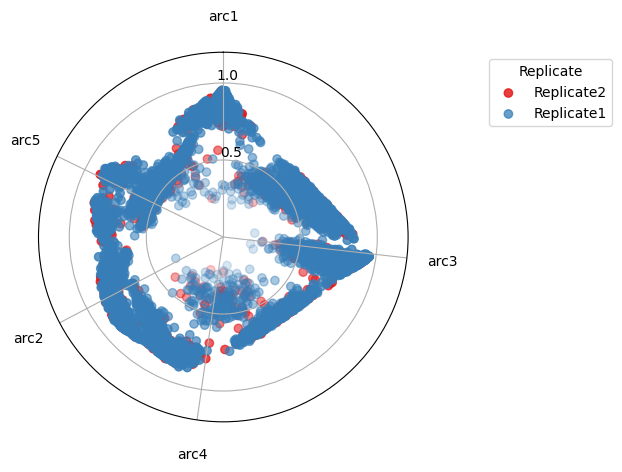

In [ ]:

fig2, ax2 = plot_archetypes_simplex(
    S_best_result,
    color_by=adata.obs["replicate"],
    l_title="Replicate",
    cmap="Set1"
)
fig2.suptitle("Archetype Simplex by Replicate (S_best_result)")
fig2.show()




AttributeError: 'Legend' object has no attribute 'legendHandles'

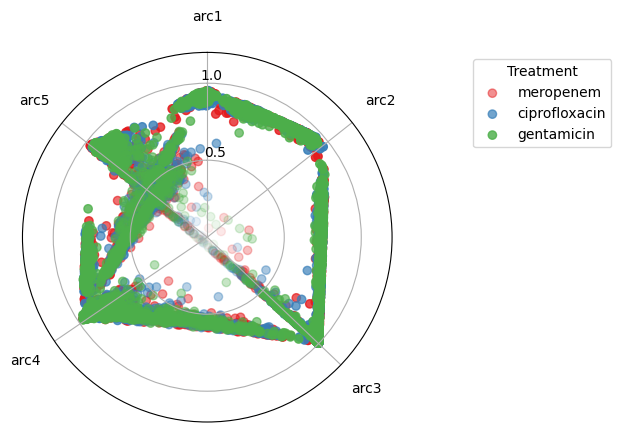

In [ ]:
# For US_best_result
fig3, ax3 = plot_archetypes_simplex(
    US_best_result,
    color_by=adata.obs["treatment"],
    l_title="Treatment",
    cmap="Set1"
)
fig3.suptitle("Archetype Simplex by Treatment (US_best_result)")
fig3.show()



AttributeError: 'Legend' object has no attribute 'legendHandles'

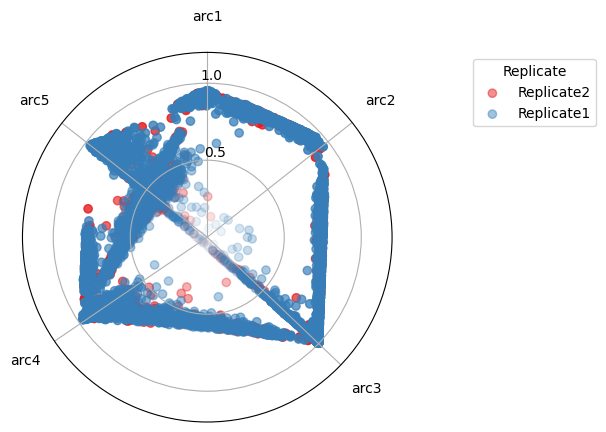

In [50]:
fig4, ax4 = plot_archetypes_simplex(
    US_best_result,
    color_by=adata.obs["replicate"],
    l_title="Replicate",
    cmap="Set1"
)
fig4.suptitle("Archetype Simplex by Replicate (US_best_result)")
fig4.show()

In [ ]:
for result, label in results:
    # By treatment
    fig1, ax1 = plot_archetypes_simplex(
        result,
        color_by=adata.obs["treatment"],
        l_title="Treatment",
        cmap="Set1"
    )
    fig1.suptitle(f"Archetype Simplex by Treatment ({label})")
    fig1.show()

    # By replicate
    fig2, ax2 = plot_archetypes_simplex(
        result,
        color_by=adata.obs["replicate"],
        l_title="Replicate",
        cmap="Set1"
    )
    fig2.suptitle(f"Archetype Simplex by Replicate ({label})")
    fig2.show()

#### b. Genetic Analysis
Built new functions for genetic analysis. Identifies the top genes per archetype

In [ ]:
import sys

sys.path.append(r"C:\Users\DG1\Desktop\DALLAB\Experimenting\Analysis")
from AA_downstream_analysis import (        
    rank_features_by_arch,
    top5_pos_neg_genes_per_archetype,
    plot_topN_genes_per_archetype,
    plot_archetype_contribution_by_treatment,
    plot_archetype_contribution_by_treatment_total,
    plot_treatment_contribution_by_archetype,
    plot_archetypes_by_treatment_and_replicate,
    top5_pos_genes_table_per_archetype,
    top5_pos_neg_genes_tables_per_archetype
)


In [ ]:
plot_archetype_contribution_by_treatment(adata, best_result, treatment_col="treatment")

In [ ]:
plot_archetype_contribution_by_treatment_total(adata, best_result, treatment_col="treatment")

In [ ]:
plot_treatment_contribution_by_archetype(adata, best_result, treatment_col="treatment")

In [ ]:
X = adata.X
inference_result = best_result
var_names = adata.var_names

In [ ]:
#ranking features ny archetype
rank_features_by_arch(
    X,
    inference_result,
    var_names,
    scale=True,   # z-score features (recommended)
)


In [ ]:
def top5_pos_neg_genes_tables_per_archetype(X, inference_result, var_names, scale=True, display=True):
    """
    For each archetype, return DataFrames of the top 5 positively and negatively associated genes,
    showing both gene name and archetype score (no color coding).
    Args:
        X: Expression matrix (cells x features)
        inference_result: dict with archetype info
        var_names: List of feature names
        scale: Whether to z-score features
        display: Whether to display the DataFrames
    Returns:
        pos_df, pos_expr_df, neg_df, neg_expr_df
    """
    import pandas as pd
    if scale:
        X = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-8)
    A = inference_result['inferred_quantities']['A']
    archetype_scores = X.T @ A
    pos_display_data = {}
    pos_expr_data = {}
    neg_display_data = {}
    neg_expr_data = {}
    for i in range(archetype_scores.shape[1]):
        # Positive genes
        idx_pos = np.argsort(-archetype_scores[:, i])[:5]
        pos_gene_names = [var_names[j] for j in idx_pos]
        pos_scores = [archetype_scores[j, i] for j in idx_pos]
        pos_expr = X[:, idx_pos].mean(axis=0)
        pos_display_data[f'Archetype {i+1}'] = [f"{g} ({s:.2f})" for g, s in zip(pos_gene_names, pos_scores)]
        pos_expr_data[f'Archetype {i+1}'] = pos_expr
        # Negative genes
        idx_neg = np.argsort(archetype_scores[:, i])[:5]
        neg_gene_names = [var_names[j] for j in idx_neg]
        neg_scores = [archetype_scores[j, i] for j in idx_neg]
        neg_expr = X[:, idx_neg].mean(axis=0)
        neg_display_data[f'Archetype {i+1}'] = [f"{g} ({s:.2f})" for g, s in zip(neg_gene_names, neg_scores)]
        neg_expr_data[f'Archetype {i+1}'] = neg_expr
    pos_df = pd.DataFrame(pos_display_data).T
    pos_df.columns = [f'Gene #{i+1}' for i in range(5)]
    pos_expr_df = pd.DataFrame(pos_expr_data).T
    pos_expr_df.columns = [f'Gene #{i+1}' for i in range(5)]
    neg_df = pd.DataFrame(neg_display_data).T
    neg_df.columns = [f'Gene #{i+1}' for i in range(5)]
    neg_expr_df = pd.DataFrame(neg_expr_data).T
    neg_expr_df.columns = [f'Gene #{i+1}' for i in range(5)]
    if display:
        try:
            from IPython.display import display as ipy_display
            print('Top 5 positively associated genes per archetype:')
            ipy_display(pos_df)
            print('Top 5 negatively associated genes per archetype:')
            ipy_display(neg_df)
        except ImportError:
            pass
    return pos_df, pos_expr_df, neg_df, neg_expr_df

In [ ]:
pos_df, pos_expr_df, neg_df, neg_expr_df = top5_pos_neg_genes_tables_per_archetype(
    X, inference_result, var_names, scale=True, display=True
)

#### Attributing function to the genes 
- difficult due to 1) reqseqID used in the dataset, and that K.pneumoniou is not super well documented

##### Automative annotation of genes from refseqID

In [ ]:
import re

def extract_core_refseq_ids(df):
    ids = set()
    # This pattern matches WP_123456789.1 after 'cds-'
    pattern = re.compile(r'cds-(WP_\d+)\.\d+')
    for col in df.columns:
        for val in df[col]:
            matches = pattern.findall(str(val))
            for match in matches:
                ids.add(match)
    return ids
# Get all unique RefSeq IDs from both tables
refseq_ids = extract_core_refseq_ids(pos_df) | extract_refseq_ids(neg_df)
print(refseq_ids)

In [ ]:
import requests

def get_uniprot_function_by_refseq(refseq_id):
    url = (
        "https://rest.uniprot.org/uniprotkb/search"
        "?query=database:(type:RefSeq%20{}%20)"
        "&fields=protein_name,gene_names,go_id,go,comment(FUNCTION)"
        "&format=tsv"
    ).format(refseq_id)
    response = requests.get(url)
    if response.ok and response.text.strip():
        lines = response.text.strip().split('\\n')
        if len(lines) > 1:
            return lines[1]  # First result after header
    return "No annotation found"

# Build a mapping from RefSeq ID to annotation
annotation_map = {}
for refseq in refseq_ids:
    annotation_map[refseq] = get_uniprot_function_by_refseq(refseq)

In [ ]:
print(annotation_map)

In [ ]:
def add_annotation(cell):
    match = re.match(r'(WP_\\d+\\.\\d+)', str(cell))
    if match:
        refseq = match.group(1)
        return f"{cell} | {annotation_map.get(refseq, 'No annotation')}"
    return cell

annotated_pos_df = pos_df.applymap(add_annotation)
annotated_neg_df = neg_df.applymap(add_annotation)

In [ ]:
from IPython.display import display
display(annotated_pos_df)
display(annotated_neg_df)